# Shear bias estimation

Martin Kilbinger, Arnau Pujol

This example notebook creates galaxy and PSF images (using galsim), measures their shapes
(with KSB/shapelens), computes the shear bias (shear response matrix), and creates a plot
of the bias as function of binned galaxy properties.

First, make sure the shear_bias package is installed and can be found.
Install the package as follows:
```bash
cd shear_bias
[sudo] python setup.py install [--prefix=<PATH>]
```
You might need super-user rights (when installing with `sudo`). Alternatively, you can specify a local path for <PATH>, e.g. ~/.local.

In [40]:
from shear_bias import *
%matplotlib inline

## Setup

Variables, file paths, and the job control are set below.

### Job control

In [2]:
job = param()

# Set re_run to True (False) if re-runs of jobs should overwrite (keep)
# previously produced output files
job.re_run = False

# Set dry_run to True (False) for jobs to run in test (real) mode
job.dry_run = False

### Shear values

In [3]:
# Small shear change for numerical derivative
dg = 0.02

In [4]:
# List of signs for shear change for the two shear components.

# Five steps (one in each direction + (0, 0)
g_steps = [(-1, 0), (0, -1), (1, 0), (0, 1), (0, 0)]

In [5]:
# Create g_dict, dictionary of shear values with step tuples as keys.
g_dict = {}
for step in g_steps:
    g_dict[step] = (step[0] * dg, step[1] * dg)
g_values = g_dict.values()

### Number of images

In [42]:
# Number of galaxy postage stamps per image is nxy_tiles^2.
# If this number is modified, all output files from a previous
# run should be deleted.
nxy_tiles = 10
#nxy_tiles = 100

# Number of files with different constant shear and PSF.
# This parameter can be changed without deleting previous output files.
nfiles    =  20
#nfiles   = 200

### File names and directories

#### Galsim

In [43]:
# Config files
galsim_config_fname     = 'csc_multishear.yaml'
galsim_config_psf_fname = 'csc_psf.yaml'
galsim_config_dir       = 'config/galsim'

# In- and outout directories
import os
great3_branch          = 'control/space/constant'
galsim_input_dir       = '{}/astro/simulations/galsim/great3/{}'.\
    format(os.environ['HOME'], great3_branch)
galsim_output_base_dir = 'output/galsim'

# Image file name formats
galsim_output_gal_fname_format = 'image-%03d-%1d.fits'
galsim_output_psf_fname_format = 'starfield_image-%03d-%1d.fits'

#### KSB-shapelens

In [44]:
# Set input directory (= galsim output directory) and output directory
ksb_input_base_dir  = galsim_output_base_dir
ksb_output_base_dir = 'output/shapelens'

#### Shear response

In [45]:
# Output directory for shear response files
R_output_dir = 'output/R'

## 2. Main program

### Download GREAT3 meta-data and PSF images.
Already downloaded files are skipped.

In [46]:
remote_dir = 'https://github.com/martinkilbinger/ede18_shear_cal/blob/master/data/great3/{}'\
   .format(great3_branch)
n_downloaded = download_great3_data(galsim_input_dir, remote_dir, great3_branch, nfiles, mode='?raw=true')

File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-000-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-001-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-002-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-003-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-004-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-005-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-006-0.fits exists, skipping...
File /Users/mkilbing/astro/simulations/galsim/great3/control/space/constant/epoch_catalog-007-0.fits exists, skipping...
File /Users/mkilbing/astro/simul

30 files downloaded


### Create images with galsim

In [47]:
# Set paths
galsim_config_path     = '{}/{}'.format(galsim_config_dir, galsim_config_fname)
galsim_config_psf_path = '{}/{}'.format(galsim_config_dir, galsim_config_psf_fname)

# Call galsim
create_all_sims_great3(g_values, galsim_config_path, galsim_config_psf_path, \
        galsim_input_dir, galsim_output_base_dir, galsim_output_gal_fname_format, \
        galsim_output_psf_fname_format, nxy_tiles=nxy_tiles, nfiles=nfiles, job=job)

*** Start create_all_sims_great3 ***
For shear (0.0,0.02), 10 images need to be created, running galsim
running galsim config/galsim/csc_multishear.yaml gal.shear.g1=0.0 gal.shear.g2=0.02 input.catalog.dir=/Users/mkilbing/astro/simulations/galsim/great3/control/space/constant input.dict.dir=/Users/mkilbing/astro/simulations/galsim/great3/control/space/constant output.dir=output/galsim/g1_0.0_g2_0.02 output.file_name.format=image-%03d-%1d.fits output.nfiles=20 image.nx_tiles=10 image.ny_tiles=10
Using config file config/galsim/csc_multishear.yaml
Using 4 processes for file processing
Start file 2 = output/galsim/g1_0.0_g2_0.02/image-002-0.fits
Start file 0 = output/galsim/g1_0.0_g2_0.02/image-000-0.fits
Start file 1 = output/galsim/g1_0.0_g2_0.02/image-001-0.fits
Start file 3 = output/galsim/g1_0.0_g2_0.02/image-003-0.fits
Process-4: File 3 = output/galsim/g1_0.0_g2_0.02/image-003-0.fits: time = 11.426273 sec
Start file 4 = output/galsim/g1_0.0_g2_0.02/image-004-0.fits
Process-4: File 4

Start file 4 = output/galsim/g1_0.02_g2_0.0/image-004-0.fits
Process-4: File 4 = output/galsim/g1_0.02_g2_0.0/image-004-0.fits: time = 7.880061 sec
Start file 5 = output/galsim/g1_0.02_g2_0.0/image-005-0.fits
Process-3: File 2 = output/galsim/g1_0.02_g2_0.0/image-002-0.fits: time = 19.153281 sec
Start file 6 = output/galsim/g1_0.02_g2_0.0/image-006-0.fits
Process-2: File 1 = output/galsim/g1_0.02_g2_0.0/image-001-0.fits: time = 20.500648 sec
Start file 7 = output/galsim/g1_0.02_g2_0.0/image-007-0.fits
Process-1: File 0 = output/galsim/g1_0.02_g2_0.0/image-000-0.fits: time = 23.242459 sec
Start file 8 = output/galsim/g1_0.02_g2_0.0/image-008-0.fits
Process-4: File 5 = output/galsim/g1_0.02_g2_0.0/image-005-0.fits: time = 8.046185 sec
Start file 9 = output/galsim/g1_0.02_g2_0.0/image-009-0.fits
Process-2: File 7 = output/galsim/g1_0.02_g2_0.0/image-007-0.fits: time = 8.464494 sec
Start file 10 = output/galsim/g1_0.02_g2_0.0/image-010-0.fits
Process-1: File 8 = output/galsim/g1_0.02_g2_0.

Start file 11 = output/galsim/g1_-0.02_g2_0.0/image-011-0.fits
Process-3: File 6 = output/galsim/g1_-0.02_g2_0.0/image-006-0.fits: time = 18.543962 sec
Start file 12 = output/galsim/g1_-0.02_g2_0.0/image-012-0.fits
Process-4: File 9 = output/galsim/g1_-0.02_g2_0.0/image-009-0.fits: time = 13.818268 sec
Start file 13 = output/galsim/g1_-0.02_g2_0.0/image-013-0.fits
Process-1: File 11 = output/galsim/g1_-0.02_g2_0.0/image-011-0.fits: time = 9.803249 sec
Process-2: File 10 = output/galsim/g1_-0.02_g2_0.0/image-010-0.fits: time = 11.028493 sec
Start file 14 = output/galsim/g1_-0.02_g2_0.0/image-014-0.fits
Start file 15 = output/galsim/g1_-0.02_g2_0.0/image-015-0.fits
Process-2: File 15 = output/galsim/g1_-0.02_g2_0.0/image-015-0.fits: time = 7.662851 sec
Start file 16 = output/galsim/g1_-0.02_g2_0.0/image-016-0.fits
Process-3: File 12 = output/galsim/g1_-0.02_g2_0.0/image-012-0.fits: time = 10.285114 sec
Start file 17 = output/galsim/g1_-0.02_g2_0.0/image-017-0.fits
Process-4: File 13 = ou

### Measure shapes with KSB (shapelens)

In [48]:
# call get_shapes
all_shapes_shapelens(g_values, ksb_input_base_dir, ksb_output_base_dir, nfiles, nxy_tiles, job=job)

*** Start all_shapes_shapelens ***
keeping existing file output/shapelens/g1_0.0_g2_0.02/result-000.txt, not running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-000-0.fits output/galsim/g1_0.0_g2_0.02/image-000-0.fits > output/shapelens/g1_0.0_g2_0.02/result-000.txt
keeping existing file output/shapelens/g1_0.0_g2_-0.02/result-000.txt, not running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-000-0.fits output/galsim/g1_0.0_g2_-0.02/image-000-0.fits > output/shapelens/g1_0.0_g2_-0.02/result-000.txt
keeping existing file output/shapelens/g1_0.02_g2_0.0/result-000.txt, not running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-000-0.fits output/galsim/g1_0.02_g2_0.0/image-000-0.fits > output/shapelens/g1_0.02_g2_0.0/result-000.txt
keeping existing file output/shapelens/g1_0.0_g2_0.0/result-000.txt, not running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-000-0.fits output/galsim/g1_0.0_g2_0.0/image-000-0.fits > output/shapelens/g1_0.0_g2_0.0/

running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-010-0.fits output/galsim/g1_0.0_g2_-0.02/image-010-0.fits > output/shapelens/g1_0.0_g2_-0.02/result-010.txt
running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-010-0.fits output/galsim/g1_0.02_g2_0.0/image-010-0.fits > output/shapelens/g1_0.02_g2_0.0/result-010.txt
running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-010-0.fits output/galsim/g1_0.0_g2_0.0/image-010-0.fits > output/shapelens/g1_0.0_g2_0.0/result-010.txt
running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-010-0.fits output/galsim/g1_-0.02_g2_0.0/image-010-0.fits > output/shapelens/g1_-0.02_g2_0.0/result-010.txt
running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-011-0.fits output/galsim/g1_0.0_g2_0.02/image-011-0.fits > output/shapelens/g1_0.0_g2_0.02/result-011.txt
running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-011-0.fits output/galsim/g1_0.0_g2_-0.02/image-011-0.fits > output/shapelens/g

running get_shapes -T -g 10 -p output/galsim/psf/starfield_image-019-0.fits output/galsim/g1_-0.02_g2_0.0/image-019-0.fits > output/shapelens/g1_-0.02_g2_0.0/result-019.txt
*** End all_shapes_shapelens ***


### Read shear estimate results from files

In [36]:
# Set input directories = KSB and galsim output directories
results_input_base_dir  = ksb_output_base_dir
psf_input_dir           = '{}/psf/'.format(galsim_output_base_dir)

# Read files
results = all_read_shapelens(g_dict, results_input_base_dir, psf_input_dir, nfiles, nobj_per_file_exp=nxy_tiles**2)

*** Start all_read_shapelens ***
Read 50 files with measured galaxy properties including shapes.
Read 0 files with PSF shapes.
*** End all_read_shapelens ***


### Compute shear response matrix and save to file

In [37]:
# Compute shear response
R = shear_response(results, dg, output_dir=R_output_dir)

*** Start shear_response ***
Saving R to file output/R
*** End shear_response ***


### Compute and print mean and std of shear response matrix

In [38]:
# If not compute above, shear response can be read from files
#R = read_R(R_output_dir)

print('mean(R)')
print(R.mean(axis=2))

print('std(R)')
print(R.std(axis=2))

mean(R)
[[ 0.94578332  0.00660148]
 [-0.00458341  0.9585898 ]]
std(R)
[[0.24169028 0.17870293]
 [0.24483201 0.28564777]]


### Plot shear response

Plot saved to snr_m1.pdf


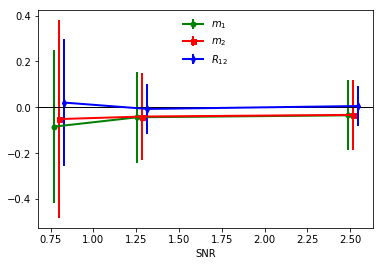

In [41]:
# Variable on x-axis
xvar  = results[(0, 0)].sn

# Variable name = xlabel
xname = 'SNR'

# Number of x-bins
nbins = 3

# Variables on y-axis, can be array for multiple curves in plot
yvar   = [shear_bias_m(R, i) for i in [0, 1]]
yvar.append(R[0,1])

# Variable names for legend
yname  = ['$m_1$', '$m_2$', '$R_{12}$']

# Color of points and error bars
color  = ['g', 'r', 'b']

# Point types
marker = ['o', 's', 'd']

# Create plot and save to file
x_mean, y_mean, y_std = \
    plot_mean_per_bin_several(xvar, xname, yvar, yname, nbins, error_mode='std', \
                              color=color, lw=2, marker=marker, out_name='snr_m1.pdf')